# Diffuse and prune edges

Here, we diffuse edge weights via adjacency multiplication, but we use quantiles of weights - per node - to determine a threshold value for pruning edges. We modify the quantile with the number of iterations in order to prune more and more edges

In [1]:
!git branch

  concensus
* master


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [17]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
from matplotlib.collections import LineCollection

sns.set()

In [4]:
import leidenalg as la
import igraph as ig
from tqdm import tqdm

## Get data

In [5]:
dataset_id=1
raw_data, targets, dataset_name = get_dataset(dataset_id=dataset_id)

k = get_dataset_params(dataset_id)['n_neighbors']
print(data_set_list[dataset_id])

coil


In [15]:
tsne_map = TSNE().fit_transform(raw_data)

/work/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/work/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [6]:
symmetric_graph, _, _ = umap.umap_.fuzzy_simplicial_set(raw_data, n_neighbors=k, metric="euclidean", random_state=42)
A_umap = symmetric_graph
# symmetric_graph[np.arange(symmetric_graph.shape[0]), np.arange(symmetric_graph.shape[0])] = 1.0
umap_graph = symmetric_graph.copy()
directed_graph, _, _ = umap.umap_.fuzzy_simplicial_set(raw_data, n_neighbors=k, metric="euclidean", random_state=42, apply_set_operations=False)
directed_graph = directed_graph.tocsr()

# Diffuse and prune

In [7]:
from sklearn.preprocessing import normalize
import scipy.sparse.csgraph

# Using quantiles to threshold

In [8]:
def get_data_larger_quantile(A_csr, quantile):
    row_quantiles = np.array([np.quantile(A_csr.data[A_csr.indptr[i]:A_csr.indptr[i+1]], quantile) for i in range(A_csr.shape[0])])
    data_filter = np.hstack([np.array([A_csr.data[A_csr.indptr[i]:A_csr.indptr[i+1]]>row_quantiles[i]]) for i in range(A_csr.shape[0])])[0]
    return(data_filter)

In [51]:
%%time
threshold = 0.001
quantiles = [0.2]*5 + [0.3]*5 + [0.5]*5 + [0.6]*5
umap_graph = normalize(directed_graph, norm="l1")
new_graph = umap_graph * umap_graph# + umap_graph
new_graph.setdiag(0)
new_graph = normalize(new_graph, norm="l1")
new_graph.data[new_graph.data < threshold] = 0.0
new_graph = normalize(new_graph, norm="l1")
new_graph.eliminate_zeros()
new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)
# new_graph = new_graph.maximum(new_graph.T)

for i in range(len(quantiles)):
    new_graph = umap_graph * new_graph# + umap_graph
    # new_graph = new_graph * umap_graph
    new_graph.setdiag(0)
    new_graph = normalize(new_graph, norm="l1")
    data_filter = get_data_larger_quantile(new_graph, quantile=quantiles[i])
    new_graph.data[~data_filter] = 0.0
    new_graph = normalize(new_graph, norm="l1")
    new_graph.eliminate_zeros()
    new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)

    # new_graph = new_graph.maximum(new_graph.T)
    
# The new graph to the power 3 - still creating new paths
new_graph = new_graph ** 3
new_graph.data[new_graph.data < threshold] = 0.0
new_graph.eliminate_zeros()
new_graph = normalize(new_graph, norm="l1")

/work/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 1.91 s, sys: 12 ms, total: 1.92 s
Wall time: 1.91 s


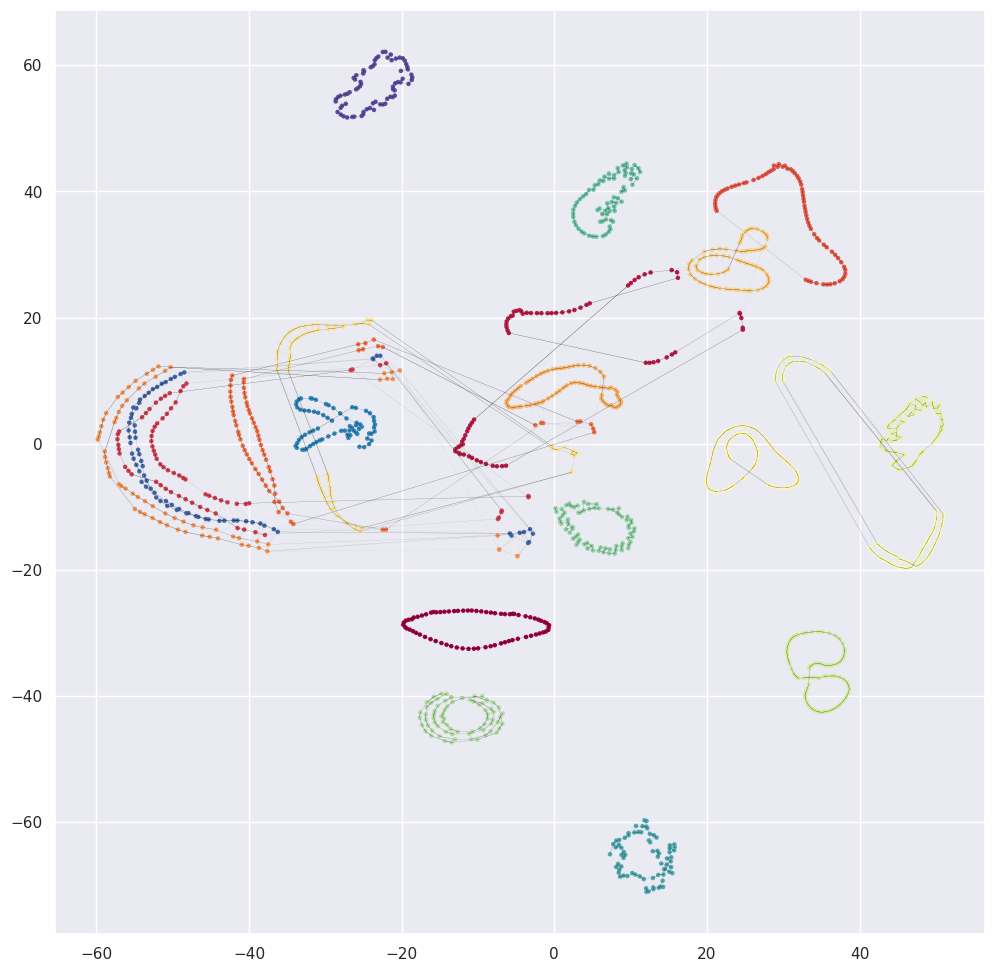

In [52]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = umap_graph.tocoo()
edges = LineCollection(
    np.dstack([tsne_map[coo_umap_graph.row], tsne_map[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=0.5 * coo_umap_graph.data, 
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), coo_umap_graph.data]).T,
    zorder=3
)
ax.add_collection(edges)

ax.scatter(*tsne_map.T, s=5, c=targets, cmap="Spectral")

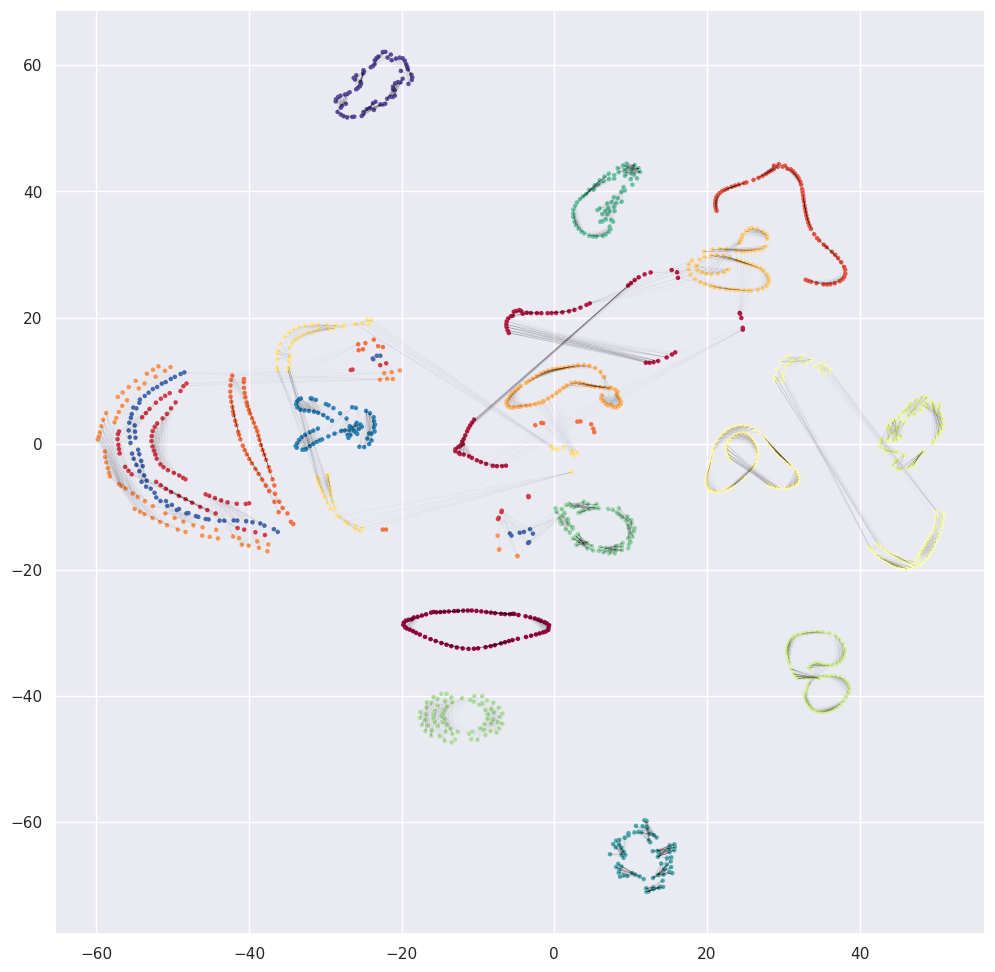

In [53]:
fig, ax = plt.subplots(figsize=(12,12))
coo_new_graph = new_graph.tocoo()
edges = LineCollection(
    np.dstack([tsne_map[coo_new_graph.row], tsne_map[coo_new_graph.col]]).transpose((0, 2, 1)), 
    linewidths=coo_new_graph.data, 
    colors=np.vstack([np.zeros((3, coo_new_graph.data.shape[0])), coo_new_graph.data]).T,
    zorder=3
)
ax.add_collection(edges)
ax.scatter(*tsne_map.T, s=5, c=targets, cmap="Spectral")

In [54]:
print(f'{umap_graph.nnz} edges before diffusion/pruning')
print(f'{new_graph.nnz} edges after diffusion/pruning')

5760 edges before diffusion/pruning
73748 edges after diffusion/pruning


# Leiden on diffused/pruned graph

In [55]:
G_orig = ig.Graph.Adjacency(new_graph>0)
clusters_orig = la.find_partition(G_orig, la.ModularityVertexPartition).membership
max(clusters_orig)+1

16

In [56]:
ari_orig = adjusted_rand_score(targets, clusters_orig)
ami_orig = adjusted_mutual_info_score(targets, clusters_orig)
print(f'ARI = {ari_orig} and AMI = {ami_orig}') 

ARI = 0.6785116508362734 and AMI = 0.9058895891153926


# HDBSCAN on diffused/pruned graph

In [57]:
def hdbscan_on_graph(distance_graph):
    if scipy.sparse.csgraph.connected_components(distance_graph)[0] > 1:
        n_components, components = scipy.sparse.csgraph.connected_components(distance_graph)
        rj_labels = np.full(distance_graph.shape[0], -1, dtype=np.int64)
        for i in range(n_components):
            if np.sum(components == i) <= 90:
                subgraph_labels = np.zeros(np.sum(components == i), dtype=np.int64)
            else:
                subgraph = distance_graph[components == i, :][:, components == i]
                subgraph_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30, allow_single_cluster=subgraph.shape[0] < 300).fit_predict(subgraph)
            subgraph_labels[subgraph_labels >= 0] += (rj_labels.max() + 1)
            rj_labels[components == i] = subgraph_labels
            print(i, np.sum(components == i), Counter(subgraph_labels))
    else:
        rj_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30).fit_predict(distance_graph)
    return(rj_labels)

In [58]:
import hdbscan
from collections import Counter

In [59]:
distance_graph = new_graph.tocsr().copy()
# distance_graph = distance_graph + distance_graph * distance_graph + distance_graph * distance_graph * distance_graph
# distance_graph = distance_graph * distance_graph
print(np.sum(distance_graph.data > 1))
distance_graph.eliminate_zeros()
distance_graph.data = -np.log(distance_graph.data)

0


In [60]:
hdb_labels = hdbscan_on_graph(distance_graph)

0 72 Counter({0: 72})
1 72 Counter({1: 72})
2 72 Counter({2: 72})
3 72 Counter({3: 72})
4 72 Counter({4: 72})
5 493 Counter({-1: 90, 9: 88, 5: 67, 12: 64, 6: 55, 10: 35, 11: 32, 7: 32, 8: 30})
6 11 Counter({13: 11})
7 72 Counter({14: 72})
8 72 Counter({15: 72})
9 72 Counter({16: 72})
10 72 Counter({17: 72})
11 72 Counter({18: 72})
12 144 Counter({-1: 77, 19: 67})
13 72 Counter({20: 72})


In [61]:
ari_hdb = adjusted_rand_score(targets, hdb_labels)
ami_hdb = adjusted_mutual_info_score(targets, hdb_labels)
print(f'ARI = {ari_hdb} and AMI = {ami_hdb}') 

ARI = 0.7147947319585449 and AMI = 0.864539852391341


# Compare against UMAP+HDBSCAN

In [43]:
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
evaluate_on = ( hd_umap_labels>=0 ) 
ari_baseline = adjusted_rand_score(targets[evaluate_on], hd_umap_labels[evaluate_on])
ami_baseline = adjusted_mutual_info_score(targets[evaluate_on], hd_umap_labels[evaluate_on])
print(f'ARI = {ari_baseline} and AMI = {ami_baseline}') 

/work/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


ARI = 0.7964599133236414 and AMI = 0.9461476533161096


In [48]:
print(f'| {data_set_list[dataset_id]} | {ari_orig:.2f}/{ami_orig:.2f} | {ari_lei:.2f}/{ami_lei:.2f} | {ari_hdb_cc:.2f}/{ami_hdb_cc:.2f} | {ari_hdb:.2f}/{ami_hdb:.2f} | {ari_baseline:.2f}/{ami_baseline:.2f} |')

| coil | 0.78/0.94 | 0.77/0.89 | 0.74/0.94 | 0.85/0.92 | 0.80/0.95 |
